# Fraction of native contacts over a trajectory

Here, we calculate the native contacts of a trajectory as a fraction of the native contacts in a given reference.

**Last updated:** January 2020

**Minimum version of MDAnalysis:** 0.21.0

**Packages required:**
    
* MDAnalysis [[1, 2]](#References)
* MDAnalysisTests
   
**Optional packages for visualisation:**

* [matplotlib](https://matplotlib.org)
* [pandas](https://pandas.pydata.org)

<div class="alert alert-info">
    
**Note**

The `contacts` module contains 3 metrics for calculating the fraction of native contacts for a conformation:

1. `hard_cut_q`: atoms *i* and *j* are in contact if they are *at least* as close as in the given reference structure
2. `soft_cut_q`: atoms *i* and *j* are in contact based on a soft potential with user-defined parameters [[3]](#References)
3. `radius_cut_q`: atoms *i* and *j* are in contact if they are within a given radius [[4]](#References)

</div>

In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD
from MDAnalysis.analysis import contacts

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Loading files

The test files we will be working with here feature adenylate kinase (AdK), a phosophotransferase enzyme. [[5]](#References) The trajectory ``DCD`` samples a transition from a closed to an open conformation.

In [2]:
u = mda.Universe(PSF, DCD)
ref = mda.Universe(PSF, DCD)

## Defining the groups for contact analysis

We define salt bridges as contacts between NH/NZ in ARG/LYS and OE\*/OD\* in ASP/GLU. You may not want to use this definition for real work.

In [3]:
sel_basic = "(resname ARG LYS) and (name NH* NZ)"
sel_acidic = "(resname ASP GLU) and (name OE* OD*)"
acidic = u.select_atoms(sel_acidic)
basic = u.select_atoms(sel_basic)

## Calculating fraction of native contacts, with a distance lower than or equal to the reference structure

`contacts.Contacts` supports each of the three methods explained above. It must be defined with a `selection` of two groups that change over time. The fraction of native contacts present in `selection` are with respect to contacts found in `refgroup`: two contacting groups in a reference configuration. Native contacts are found in the reference group `refgroup` based on the radius.

Below, we just use the atomgroups in the universe at the current frame as a reference.

In [4]:
ca1 = contacts.Contacts(u, 
                        selection=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic), 
                        radius=4.5, 
                        method='hard_cut').run()

The results are available as a numpy array at `ca1.timeseries`. The first column is the frame, and the second is the fraction of contacts present in that frame.

In [15]:
ca1_df = pd.DataFrame(ca1.timeseries, 
                      columns=['Frame', 
                               'Contacts from first frame'])
ca1_df.head()

,Frame,Contacts from first frame
0,0.0,1.000000
1,1.0,0.492754
2,2.0,0.449275
3,3.0,0.507246
4,4.0,0.463768


Note that the data is presented as fractions of the native contacts present in the reference configuration. In order to find the number of contacts present, multiply the data with the number of contacts in the reference configuration.

In [25]:
ref_distance = contacts.distance_array(acidic.positions, 
                                       basic.positions)
ref_contacts = contacts.contact_matrix(ref_distance, radius=4.5)
n_ref = ref_contacts.sum()
print('There are {} contacts in the reference.'.format(n_ref))

There are 69 contacts in the reference.


In [27]:
n_contacts = ca1.timeseries[:, 1] * n_ref
print(n_contacts[:5])

[69. 34. 31. 35. 32.]


### Plotting

Text(0, 0.5, 'Fraction of contacts')

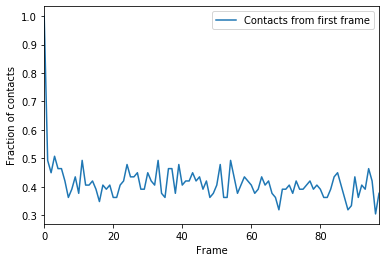

In [6]:
ca1_df.plot(x='Frame')
plt.ylabel('Fraction of contacts')

## Calculating fraction of native contacts, with pairs assigned based on a soft potential

`refgroup` can either be two contacting groups in a reference configuration, or a list of tuples of two contacting groups. Below, we set the reference trajectory to its last frame and select another pair of contacting atomgroups.

In [7]:
ref.trajectory[-1]
acidic_2 = ref.select_atoms(sel_acidic)
basic_2 = ref.select_atoms(sel_basic)

This time we will use the `soft_cut_q` algorithm to calculate contacts by setting `method='soft_cut'`. This method uses the soft potential below to determine if atoms are in contact:

$$ Q(r, r_0) = \frac{1}{1 + e^{\beta (r - \lambda r_0)}} $$

$r$ is a distance array and $r0$ are the distances in the reference group. $\beta$ controls the softness of the switching function and $\lambda$ is the tolerance of the reference distance.

Suggested values for $\lambda$ is 1.8 for all-atom simulations and 1.5 for coarse-grained simulations. The default value of $\beta$ is 5.0. To change these, pass `kwargs` to contacts.Contacts.

In [16]:
ca2 = contacts.Contacts(u, selection=(sel_acidic, sel_basic),
                        refgroup=[(acidic, basic), (acidic_2, basic_2)], 
                        radius=4.5, 
                        method='soft_cut',
                        kwargs={'beta': 5.0,
                                'lambda_constant': 1.5}).run()

Again, the first column of the data array in `ca2.timeseries` is the frame. The next columns of the array are fractions of native contacts with reference to the `refgroup`s passed, in order.

In [17]:
ca2_df = pd.DataFrame(ca2.timeseries, 
                      columns=['Frame', 
                               'Contacts from first frame', 
                               'Contacts from last frame'])
ca2_df.head()

,Frame,Contacts from first frame,Contacts from last frame
0,0.0,0.999094,0.719242
1,1.0,0.984928,0.767501
2,2.0,0.984544,0.788027
3,3.0,0.970184,0.829219
4,4.0,0.980425,0.833500


### Plotting

Again, we can plot over time.

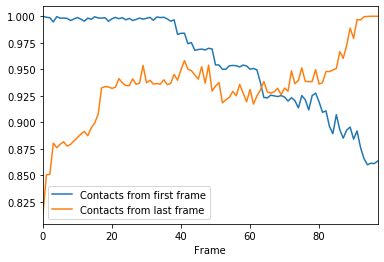

In [10]:
ca2_df.plot(x='Frame')

We can also plot the fraction of salt bridges from the first frame, over the fraction from the last frame, as a way to characterise the transition of the protein from closed to open.

Text(0, 0.5, 'Contacts from last frame')

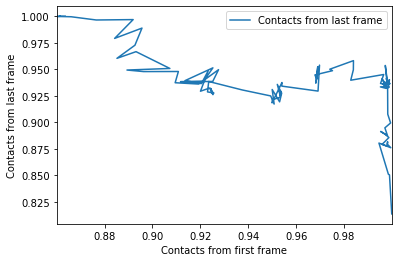

In [11]:
ca2_df.plot(x='Contacts from first frame', y='Contacts from last frame')
plt.ylabel('Contacts from last frame')

## Calculating contacts within a cutoff

We can also determine the fraction of native contacts within a certain radius cutoff using `radius_cut_q`.

In [12]:
ca3 = contacts.Contacts(u, selection=(sel_acidic, sel_basic),
                        refgroup=[(acidic, basic)], 
                        radius=4.5, 
                        method='radius_cut').run()

In [18]:
ca3_df = pd.DataFrame(ca3.timeseries, 
                      columns=['Frame', 
                               'Contacts from first frame'])
ca3_df.head()

,Frame,Contacts from first frame
0,0.0,1.000000
1,1.0,0.971014
2,2.0,0.956522
3,3.0,0.956522
4,4.0,0.956522


### Plotting

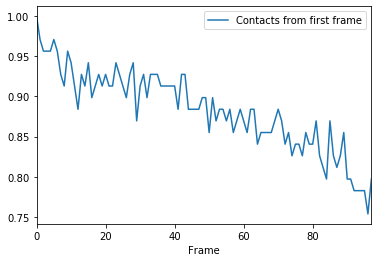

In [14]:
ca3_df.plot(x='Frame')

## References

[1]: R. J. Gowers, M. Linke, J. Barnoud, T. J. E. Reddy, M. N. Melo, S. L. Seyler, D. L. Dotson, J. Domanski, S. Buchoux, I. M. Kenney, and O. Beckstein. [MDAnalysis: A Python package for the rapid analysis of molecular dynamics simulations](http://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html). In S. Benthall and S. Rostrup, editors, *Proceedings of the 15th Python in Science Conference*, pages 98-105, Austin, TX, 2016. SciPy, [doi:10.25080/majora-629e541a-00e](https://doi.org/10.25080/majora-629e541a-00e).

[2]: N. Michaud-Agrawal, E. J. Denning, T. B. Woolf, and O. Beckstein. MDAnalysis: A Toolkit for the Analysis of Molecular Dynamics Simulations. *J. Comput. Chem*. 32 (2011), 2319-2327, doi:[10.1002/jcc.21787](https://dx.doi.org/10.1002/jcc.21787). PMCID:[PMC3144279](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144279/)

[3]: R.B. Best, G. Hummer, and W.A. Eaton, "Native contacts determine protein folding mechanisms in atomistic simulations" *PNAS*. 110 (2013), 17874–17879. doi: [10.1073/pnas.1311599110](http://doi.org/10.1073/pnas.1311599110>)

[4]: Franklin, J., Koehl, P., Doniach, S., & Delarue, M. (2007).  MinActionPath: Maximum likelihood trajectory for large-scale structural transitions in a coarse-grained locally harmonic energy landscape.  *Nucleic Acids Research*, 35(SUPPL.2), 477–482. [doi:10.1093/nar/gkm342](http://doi.org/10.1093/nar/gkm342)

[5]: O. Beckstein, E.J. Denning, J.R. Perilla, T.B. Woolf. Zipping and unzipping of adenylate kinase: atomistic insights into the ensemble of open<-->closed transitions. *J Mol Biol*. 2009;394(1):160–176. [doi:10.1016/j.jmb.2009.09.009](https://dx.doi.org/10.1016%2Fj.jmb.2009.09.009)